In [1]:
opt = {
    outchan = 3,
    inchan = 3,
    outsize = 64,
--     lambda = 1, -- controls what proportion of loss is L1 
    lambda = 0.99, -- controls what proportion of loss is L1 
    num_frames = 3,
    ngf = 3,
    momentum = 0.5,
    num_iter = 1000,
    batchsize = 32,
    valSize = 32,
    gpu = false
}

In [2]:
function string:split( inSplitPattern, outResults )
  if not outResults then
    outResults = { }
  end
  local theStart = 1
  local theSplitStart, theSplitEnd = string.find( self, inSplitPattern, 
theStart )
  while theSplitStart do
    table.insert( outResults, string.sub( self, theStart, theSplitStart-1 ) )
    theStart = theSplitEnd + 1
    theSplitStart, theSplitEnd = string.find( self, inSplitPattern, theStart )
  end
  table.insert( outResults, string.sub( self, theStart ) )
  return outResults
end

In [3]:
require 'image'
torch.setdefaulttensortype('torch.FloatTensor')

if opt.gpu then
    require 'cutorch'
    require 'cunn'
end

invidnames = {}
input_imgs = torch.FloatTensor()
label_imgs = torch.FloatTensor()
valimgs = torch.FloatTensor()
vallabels = torch.FloatTensor()

directory = 'small_dataset_64/'

for file in paths.files(directory) do
    if file:find('invidnames.t7' .. '$') then
        invidnames = torch.load(directory .. 'invidnames.t7')
    end
    if file:find('input_imgs.t7' .. '$') then
        input_imgs = torch.load(directory .. 'input_imgs.t7')
    end
    if file:find('label_imgs.t7' .. '$') then
        label_imgs = torch.load(directory .. 'label_imgs.t7')
    end
    if file:find('valvidnames.t7' .. '$') then
        valvidnames = torch.load(directory .. 'valvidnames.t7')
    end
    if file:find('valimgs.t7' .. '$') then
        valimgs = torch.load(directory .. 'valimgs.t7')
    end
    if file:find('vallabels.t7' .. '$') then
        vallabels = torch.load(directory .. 'vallabels.t7')
    end
end

print('Images loaded')

Images loaded	


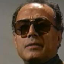

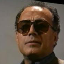

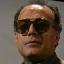

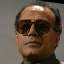

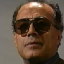

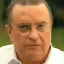

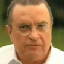

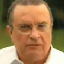

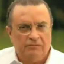

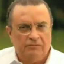

In [4]:
if not opt.gpu then
    for i = 1,5 do
       itorch.image(input_imgs[i])
    end
    for i = 1,5 do
       itorch.image(label_imgs[i])
    end
    for i = 1,5 do
       itorch.image(valimgs[i])
    end
    for i = 1,5 do
       itorch.image(vallabels[i])
    end
end


In [5]:
require 'nn'


-- input: inchan x 16 x 16
gen = nn.Sequential()

if opt.outsize == 32 then
    gen:add(nn.SpatialConvolution(opt.outchan * opt.num_frames, opt.ngf * 16, 4, 4, 2, 2, 1, 1))
    gen:add(nn.ReLU(true))
    -- -- size: opt.ngf * 16 x 8 x 8 

    gen:add(nn.SpatialFullConvolution(opt.ngf * 16, opt.ngf * 8, 4, 4, 2, 2, 1, 1))
    gen:add(nn.ReLU(true))
    -- -- size: opt.ngf * 8 x 16 x 16 

    gen:add(nn.SpatialFullConvolution(opt.ngf * 8, opt.outchan, 4, 4, 2, 2, 1, 1))
    gen:add(nn.ReLU(true))
    -- size: opt.ngf * 8 x 32 x 32 

else
    gen:add(nn.SpatialConvolution(opt.outchan * opt.num_frames, opt.ngf * 16, 4, 4, 2, 2, 1, 1))
    gen:add(nn.ReLU(true))
    -- -- size: opt.ngf * 16 x 8 x 8 

    gen:add(nn.SpatialFullConvolution(opt.ngf * 16, opt.ngf * 8, 4, 4, 2, 2, 1, 1))
    gen:add(nn.ReLU(true))
    -- -- size: opt.ngf * 8 x 16 x 16 

    gen:add(nn.SpatialFullConvolution(opt.ngf * 8, opt.ngf * 4, 4, 4, 2, 2, 1, 1))
    gen:add(nn.ReLU(true))
    -- size: opt.ngf * 8 x 32 x 32 

    gen:add(nn.SpatialFullConvolution(opt.ngf * 4, opt.outchan, 4, 4, 2, 2, 1, 1))
    gen:add(nn.ReLU(true))
    -- size: opt.ngf * 4 x 64 x 64 
end


-- gen:add(nn.SpatialConvolution(opt.outchan * opt.num_frames, opt.ngf * 16, 4, 4, 2, 2, 1, 1))
-- gen:add(nn.ReLU(true))
-- -- size: opt.ngf * 16 x 8 x 8 

-- gen:add(nn.SpatialUpSamplingNearest(2))
-- gen:add(nn.SpatialDilatedConvolution(opt.ngf * 16, opt.ngf * 8, 4, 4, 1, 1, 3, 3, 2, 2))
-- gen:add(nn.ReLU(true))
-- -- size: opt.ngf * 8 x 16 x 16 

-- gen:add(nn.SpatialUpSamplingNearest(2))
-- gen:add(nn.SpatialDilatedConvolution(opt.ngf * 8, opt.ngf * 4, 4, 4, 1, 1, 3, 3, 2, 2))
-- gen:add(nn.ReLU(true))
-- -- size: opt.ngf * 8 x 32 x 32 

-- gen:add(nn.SpatialUpSamplingNearest(2))
-- gen:add(nn.SpatialDilatedConvolution(opt.ngf * 4, opt.outchan, 4, 4, 1, 1, 3, 3, 2, 2))
-- gen:add(nn.ReLU(true))
-- -- size: opt.ngf * 4 x 64 x 64 



disc = nn.Sequential()


if opt.outsize == 32 then
    disc:add(nn.SpatialConvolution(opt.outchan, opt.outchan * 2, 4, 4, 2, 2, 1, 1))
    disc:add(nn.SpatialBatchNormalization(opt.outchan * 2)):add(nn.LeakyReLU(0.2, true))
    -- size: opt.outchan * 2 x 16 x 16

    disc:add(nn.SpatialConvolution(opt.outchan * 2, opt.outchan * 4, 4, 4, 2, 2, 1, 1))
    disc:add(nn.SpatialBatchNormalization(opt.outchan * 4)):add(nn.LeakyReLU(0.2, true))
    -- size: opt.outchan * 4 x 8 x 8

    disc:add(nn.SpatialConvolution(opt.outchan * 4, opt.outchan * 8, 4, 4, 2, 2, 1, 1))
    disc:add(nn.SpatialBatchNormalization(opt.outchan * 8)):add(nn.LeakyReLU(0.2, true))
    -- size: opt.outchan * 8 x 4 x 4

    disc:add(nn.SpatialConvolution(opt.outchan * 8, 1, 4, 4))
    disc:add(nn.Sigmoid())
    -- size: 1 x 1 x 1
else
    disc:add(nn.SpatialConvolution(opt.outchan, opt.outchan * 2, 4, 4, 2, 2, 1, 1))
    disc:add(nn.SpatialBatchNormalization(opt.outchan * 2)):add(nn.LeakyReLU(0.2, true))
    -- size: opt.outchan * 2 x 32 x 32

    disc:add(nn.SpatialConvolution(opt.outchan * 2, opt.outchan * 4, 4, 4, 2, 2, 1, 1))
    disc:add(nn.SpatialBatchNormalization(opt.outchan * 4)):add(nn.LeakyReLU(0.2, true))
    -- size: opt.outchan * 4 x 16 x 16

    disc:add(nn.SpatialConvolution(opt.outchan * 4, opt.outchan * 8, 4, 4, 2, 2, 1, 1))
    disc:add(nn.SpatialBatchNormalization(opt.outchan * 8)):add(nn.LeakyReLU(0.2, true))
    -- size: opt.outchan * 8 x 8 x 8

    disc:add(nn.SpatialConvolution(opt.outchan * 8, opt.outchan * 16, 4, 4, 2, 2, 1, 1))
    disc:add(nn.SpatialBatchNormalization(opt.outchan * 16)):add(nn.LeakyReLU(0.2, true))
    -- size: opt.outchan * 16 x 4 x 4

    disc:add(nn.SpatialConvolution(opt.outchan * 16, 1, 4, 4))
    disc:add(nn.Sigmoid())
    -- size: 1 x 1 x 1
end

disc:add(nn.View(1):setNumInputDims(3))
disc:add(nn.Squeeze())
-- size: 1

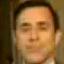

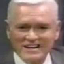

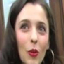

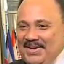

In [6]:
-- generate smaller validation set with previous and subsequent frames
valinputs = torch.FloatTensor(opt.valSize, opt.num_frames * opt.inchan, 16, 16)
valtruths = torch.FloatTensor(opt.valSize, opt.inchan, opt.outsize, opt.outsize)

for vi = 1, opt.valSize do
    local rand_id = torch.random(2, valimgs:size(1) - 1)
    while not (valvidnames[rand_id] == valvidnames[rand_id - 1] and valvidnames[rand_id] == valvidnames[rand_id + 1]) do
        rand_id = torch.random(2, valimgs:size(1) - 1)
    end
    valinputs[vi] = torch.cat(valimgs[rand_id - 1], valimgs[rand_id], 1):cat(valimgs[rand_id + 1], 1)
    valtruths[vi] = vallabels[rand_id]
end

-- if not opt.gpu then
--     for vi = 1, 4 do
--         itorch.image(valinputs[vi])
--         itorch.image(valtruths[vi])
--     end
-- end


-- test construct batch
inputs = torch.FloatTensor(opt.batchsize, opt.inchan * opt.num_frames, 16, 16)
labels = torch.FloatTensor(opt.batchsize, opt.outchan, opt.outsize, opt.outsize)

for bi = 1, opt.batchsize do
    local rand_id = torch.random(2, input_imgs:size(1) - 1)
    while not(invidnames[rand_id] == invidnames[rand_id - 1] and invidnames[rand_id] == invidnames[rand_id + 1]) do
        rand_id = torch.random(2, input_imgs:size(1) - 1)
    end  
    inputs[bi] = torch.cat(input_imgs[rand_id - 1], input_imgs[rand_id], 1):cat(input_imgs[rand_id + 1], 1)
    labels[bi] = label_imgs[rand_id]
end
if not opt.gpu then
    for bi = 1, 4 do
        itorch.image(inputs[{bi, {4,6}, {}, {}}])
--         itorch.image(inputs[bi])
        itorch.image(labels[bi])
    end
end

-- gen = torch.load('srez_model_video_16_to_32.t7')
gen = torch.load('small_dataset_64/srez_model_gen_16_to_64.t7')
if opt.gpu then
    input_imgs = input_imgs:cuda()
    label_imgs = label_imgs:cuda()
    valimgs = valimgs:cuda()
    vallabels = vallabels:cuda()
    valinputs = valinputs:cuda()
    valtruths = valtruths:cuda()
    gen = gen:cuda()
    disc = disc:cuda()
end

In [7]:
require 'optim'

criterionG = nn.AbsCriterion()
criterionD = nn.BCECriterion()
if opt.gpu then
    criterionG:cuda()
    criterionD:cuda()
end

local optimStateD = {learningRate = 0.001, beta1 = opt.momentum}
local optimStateG = {learningRate = 0.001, beta1 = opt.momentum}

real_label = 1
fake_label = 0

inputs = torch.FloatTensor(opt.batchsize, opt.inchan * opt.num_frames, 16, 16)
labels = torch.FloatTensor(opt.batchsize, opt.outchan, opt.outsize, opt.outsize)
-- upinputs = torch.FloatTensor(opt.batchsize, opt.outchan, opt.outsize, opt.outsize)
disclabels = torch.FloatTensor(opt.batchsize)
valdisclabels = torch.FloatTensor(opt.valSize)
if opt.gpu then
    inputs = inputs:cuda()
    labels = labels:cuda()
--     upinputs = upinputs:cuda()
    disclabels = disclabels:cuda()
    valdisclabels = valdisclabels:cuda()
end
outputs = nil

iter_tm = torch.Timer()
total_tm = torch.Timer()
for iter = 1, opt.num_iter do
    
    -- construct batch
    for bi = 1, opt.batchsize do
        local rand_id = torch.random(2, input_imgs:size(1) - 1)
        while not(invidnames[rand_id] == invidnames[rand_id - 1] and invidnames[rand_id] == invidnames[rand_id + 1]) do
            rand_id = torch.random(2, input_imgs:size(1) - 1)
        end  
        inputs[bi] = torch.cat(input_imgs[rand_id - 1], input_imgs[rand_id], 1):cat(input_imgs[rand_id + 1], 1)
        labels[bi] = label_imgs[rand_id]
--         upinputs[bi] = image.scale(input_imgs[rand_id], 64, 64, 'simple')
    end
    
    paramsG, gradParamsG = gen:getParameters()
    paramsD, gradParamsD = disc:getParameters()
    
    -- evaluation, forwards/backward pass for discriminator
    fDx = function(paramsD)
        gradParamsD:zero()
        
        disclabels:fill(real_label)
        local output = disc:forward(labels)
        local errD_real = criterionD:forward(output, disclabels)
        local df_do = criterionD:backward(output, disclabels)
        disc:backward(labels, df_do)
        
        disclabels:fill(fake_label)
        outputs = gen:forward(inputs)
        local output = disc:forward(outputs)
        local errD_fake = criterionD:forward(output, disclabels)
        local df_do = criterionD:backward(output, disclabels)
        disc:backward(outputs, df_do)

        errD = (errD_real + errD_fake) / 2
        
        return errD, gradParamsD
    end
    
    -- evaluation, forwards/backward pass for generator
    fGx = function(paramsG)
        gradParamsG:zero()

        disclabels:fill(real_label)
        
        errG = criterionD:forward(disc.output, disclabels)
        
--         df_doG = criterionG:backward(outputs, upinputs)
        df_doG = criterionG:backward(outputs, labels)
        df_doD = criterionD:backward(disc.output, disclabels)
        
        df_dg = disc:updateGradInput(outputs, df_doD)
        
        gen:backward(inputs, df_dg * (1 - opt.lambda) + df_doG * opt.lambda)
        return errG, gradParamsG
    end
    
    
    -- train
--     fDx(paramsD)
    optim.adam(fDx, paramsD, optimStateD)
    optim.adam(fGx, paramsG, optimStateG)
    
    if iter % (opt.num_iter / 10) == 0 then
        optimStateG.learningRate = optimStateG.learningRate / 2
        optimStateD.learningRate = optimStateD.learningRate / 2
    end

    -- validate
    if iter % (opt.num_iter / 20) == 0 then
        outputs = gen:forward(valinputs)
        if not opt.gpu then
            for vi = 1, 4 do
--                 itorch.image(valinputs[vi])
--                 itorch.image(outputs[vi])
                itorch.image(image.scale(valinputs[{vi, {4,6}, {}, {}}], 64, 64, 'simple'))
                itorch.image(image.scale(outputs[vi], 64, 64, 'simple'))
            end
        end
        valdisclabels:fill(real_label)
        l1err = criterionG:forward(outputs, valtruths)
        discerr = criterionD:forward(disc:forward(outputs), valdisclabels)
        valerr = l1err * opt.lambda + discerr * (1 - opt.lambda)
        print(('\nvalidation error at iter = %d is %.4f \t Time Taken: %.3f'):format(iter, valerr, iter_tm:time().real))
        print(('L1 error = %.4f, discriminator error = %.4f'):format(l1err, discerr))
        
        iter_tm:reset()
    end
    gen:clearState()
end
print(('\n total time taken: %.3f'):format(total_tm:time().real))
gen = gen:float()
disc = disc:float()
torch.save('srez_model_gen_local.t7', gen)
torch.save('srez_model_disc_local.t7', disc)

...nicholas/torch/install/share/lua/5.1/nn/AbsCriterion.lua:27: attempt to index local 'target' (a nil value)
stack traceback:
	...nicholas/torch/install/share/lua/5.1/nn/AbsCriterion.lua:27: in function 'backward'
	[string "require 'optim'..."]:78: in function 'opfunc'
	/home/nicholas/torch/install/share/lua/5.1/optim/adam.lua:37: in function 'adam'
	[string "require 'optim'..."]:92: in main chunk
	[C]: in function 'xpcall'
	/home/nicholas/torch/install/share/lua/5.1/itorch/main.lua:210: in function </home/nicholas/torch/install/share/lua/5.1/itorch/main.lua:174>
	/home/nicholas/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	.../nicholas/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	.../nicholas/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	.../nicholas/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/home/nicholas/torch/install/share/lua/5.1/itorch/main.lua:389: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00405d50: 